# Random Bloch Sphere Observables: Classical Shadows vs Baselines

This notebook benchmarks classical shadows against direct measurement for **arbitrary single-qubit observables**.

**Key Insight:** 
- Observables on **different qubits** commute and CAN be grouped
- Observables on the **same qubit** with different Bloch directions do NOT commute
- This creates a middle ground: some grouping is possible, but not as efficient as standard Pauli measurements

**Observable Definition:**
Each observable is a random unit vector on the Bloch sphere:
$$O_i = \sin(\theta_i)\cos(\phi_i) X_{q_i} + \sin(\theta_i)\sin(\phi_i) Y_{q_i} + \cos(\theta_i) Z_{q_i}$$

where $q_i$ is a randomly chosen qubit, and $(\theta_i, \phi_i)$ are random spherical coordinates.

**Protocols Compared:**
1. **DirectNaive**: One circuit per observable, shots split equally
2. **DirectGrouped**: Group observables on different qubits, measure simultaneously
3. **DirectOptimized**: Grouped + optimal shot allocation
4. **Classical Shadows**: Random Pauli measurements, data reused for ALL observables

In [28]:
# --- Setup and imports ---
import sys
from pathlib import Path
from dataclasses import dataclass
from typing import Optional
import json

import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm

sys.path.insert(0, '../src')

from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector, Operator

print("Setup complete!")

Setup complete!


## 1. Configuration

**Key parameters:**
- `M_OBSERVABLES`: Number of random Bloch observables
- `N_QUBITS`: System size
- `N_SHOTS`: Total measurement budget

In [29]:
# =============================================================================
# KEY PARAMETERS
# =============================================================================
M_OBSERVABLES = 30       # Number of random Bloch sphere observables
N_QUBITS = 3             # Number of qubits
N_SHOTS_GRID = [100, 200, 500, 1000]  # Shot budgets to test
N_REPLICATES = 20        # Statistical replicates
SEED = 42

# Output directory with timestamp (format: name_D_M_YYYY_HHMM)
from datetime import datetime
now = datetime.now()
timestamp = f"{now.day}_{now.month}_{now.year}_{now.hour:02d}{now.minute:02d}"
OUTPUT_DIR = Path(f'results/bloch_m{M_OBSERVABLES}_n{N_QUBITS}_benchmark_{timestamp}')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Set random seed
rng = np.random.default_rng(SEED)

print(f"Configuration:")
print(f"  - Observables (M): {M_OBSERVABLES}")
print(f"  - Qubits (n): {N_QUBITS}")
print(f"  - Shot grid: {N_SHOTS_GRID}")
print(f"  - Replicates: {N_REPLICATES}")
print(f"  - Output: {OUTPUT_DIR}")

Configuration:
  - Observables (M): 30
  - Qubits (n): 3
  - Shot grid: [100, 200, 500, 1000]
  - Replicates: 20
  - Output: results\bloch_m30_n3_benchmark_9_1_2026_1413


## 2. Generate Random Bloch Sphere Observables

Each observable is defined by:
- A random qubit index
- A random direction on the Bloch sphere (θ, φ)

In [30]:
@dataclass
class BlochObservable:
    """A single-qubit observable in an arbitrary Bloch sphere direction.
    
    O = nx * X + ny * Y + nz * Z
    where (nx, ny, nz) is a unit vector parameterized by (theta, phi).
    """
    qubit: int
    theta: float  # Polar angle [0, pi]
    phi: float    # Azimuthal angle [0, 2*pi]
    obs_id: str = ""
    
    @property
    def nx(self) -> float:
        return np.sin(self.theta) * np.cos(self.phi)
    
    @property
    def ny(self) -> float:
        return np.sin(self.theta) * np.sin(self.phi)
    
    @property
    def nz(self) -> float:
        return np.cos(self.theta)
    
    @property
    def bloch_vector(self) -> np.ndarray:
        return np.array([self.nx, self.ny, self.nz])
    
    def __repr__(self):
        return f"BlochObs(q={self.qubit}, n=[{self.nx:.2f}, {self.ny:.2f}, {self.nz:.2f}])"


def generate_random_bloch_observables(
    n_qubits: int,
    m_observables: int,
    rng: np.random.Generator,
) -> list[BlochObservable]:
    """Generate M random Bloch sphere observables.
    
    Each observable acts on a random qubit with a random direction.
    Directions are uniformly distributed on the sphere.
    """
    observables = []
    
    for i in range(m_observables):
        # Random qubit
        qubit = rng.integers(0, n_qubits)
        
        # Random direction (uniform on sphere)
        # theta: arccos of uniform [-1, 1] gives uniform distribution on sphere
        theta = np.arccos(2 * rng.random() - 1)
        phi = 2 * np.pi * rng.random()
        
        obs = BlochObservable(
            qubit=qubit,
            theta=theta,
            phi=phi,
            obs_id=f"bloch_{i:04d}",
        )
        observables.append(obs)
    
    return observables


# Generate observables
bloch_observables = generate_random_bloch_observables(N_QUBITS, M_OBSERVABLES, rng)

print(f"Generated {len(bloch_observables)} random Bloch observables")
print(f"\nFirst 10 observables:")
for obs in bloch_observables[:10]:
    print(f"  {obs}")

# Count observables per qubit
qubit_counts = {}
for obs in bloch_observables:
    qubit_counts[obs.qubit] = qubit_counts.get(obs.qubit, 0) + 1
print(f"\nObservables per qubit: {dict(sorted(qubit_counts.items()))}")

Generated 30 random Bloch observables

First 10 observables:
  BlochObs(q=0, n=[0.63, -0.77, -0.12])
  BlochObs(q=2, n=[0.76, 0.51, 0.39])
  BlochObs(q=1, n=[0.19, -0.83, 0.52])
  BlochObs(q=2, n=[-0.64, 0.21, -0.74])
  BlochObs(q=1, n=[-0.32, -0.41, 0.85])
  BlochObs(q=1, n=[-0.72, 0.27, 0.65])
  BlochObs(q=1, n=[0.92, 0.39, 0.11])
  BlochObs(q=0, n=[-0.51, -0.56, 0.66])
  BlochObs(q=0, n=[0.94, -0.18, -0.29])
  BlochObs(q=2, n=[0.11, -0.61, 0.79])

Observables per qubit: {np.int64(0): 8, np.int64(1): 9, np.int64(2): 13}


## 3. Test Circuit (GHZ State)

We use a GHZ state which has interesting single-qubit expectations.

In [31]:
def build_ghz(n_qubits: int) -> QuantumCircuit:
    """Build a GHZ state preparation circuit."""
    qc = QuantumCircuit(n_qubits)
    qc.h(0)
    for i in range(1, n_qubits):
        qc.cx(i - 1, i)
    return qc

circuit = build_ghz(N_QUBITS)
print(circuit.draw('text'))

     ┌───┐          
q_0: ┤ H ├──■───────
     └───┘┌─┴─┐     
q_1: ─────┤ X ├──■──
          └───┘┌─┴─┐
q_2: ──────────┤ X ├
               └───┘


## 4. Compute Ground Truth

Calculate exact expectation values using statevector simulation.

In [32]:
# Pauli matrices
I = np.array([[1, 0], [0, 1]], dtype=complex)
X = np.array([[0, 1], [1, 0]], dtype=complex)
Y = np.array([[0, -1j], [1j, 0]], dtype=complex)
Z = np.array([[1, 0], [0, -1]], dtype=complex)


def compute_bloch_expectation(statevector: np.ndarray, obs: BlochObservable, n_qubits: int) -> float:
    """Compute <psi| O |psi> for a Bloch observable.
    
    O = nx * X_q + ny * Y_q + nz * Z_q
    """
    # Build the full operator: I ⊗ ... ⊗ O_q ⊗ ... ⊗ I
    pauli_q = obs.nx * X + obs.ny * Y + obs.nz * Z
    
    # Tensor product (Qiskit uses little-endian ordering)
    # qubit 0 is rightmost in tensor product
    ops = [I] * n_qubits
    ops[obs.qubit] = pauli_q
    
    # Build full operator (reverse for Qiskit convention)
    full_op = ops[n_qubits - 1]
    for i in range(n_qubits - 2, -1, -1):
        full_op = np.kron(full_op, ops[i])
    
    # Compute expectation
    expectation = np.real(statevector.conj() @ full_op @ statevector)
    return expectation


# Get statevector
sv = Statevector.from_instruction(circuit)
statevector = sv.data

# Compute ground truth for all observables
ground_truth = {}
for obs in bloch_observables:
    truth = compute_bloch_expectation(statevector, obs, N_QUBITS)
    ground_truth[obs.obs_id] = truth

print(f"Computed ground truth for {len(ground_truth)} observables")
print(f"\nFirst 10 expectation values:")
for obs in bloch_observables[:10]:
    print(f"  {obs.obs_id}: <O> = {ground_truth[obs.obs_id]:.6f}")

# Statistics
truth_values = list(ground_truth.values())
print(f"\nGround truth statistics:")
print(f"  Mean: {np.mean(truth_values):.6f}")
print(f"  Std:  {np.std(truth_values):.6f}")
print(f"  Min:  {np.min(truth_values):.6f}")
print(f"  Max:  {np.max(truth_values):.6f}")

Computed ground truth for 30 observables

First 10 expectation values:
  bloch_0000: <O> = 0.000000
  bloch_0001: <O> = 0.000000
  bloch_0002: <O> = 0.000000
  bloch_0003: <O> = 0.000000
  bloch_0004: <O> = 0.000000
  bloch_0005: <O> = 0.000000
  bloch_0006: <O> = 0.000000
  bloch_0007: <O> = 0.000000
  bloch_0008: <O> = 0.000000
  bloch_0009: <O> = 0.000000

Ground truth statistics:
  Mean: 0.000000
  Std:  0.000000
  Min:  0.000000
  Max:  0.000000


## 5. Classical Shadows Protocol

Random Pauli measurements can estimate ANY observable.

For a Bloch observable $O = n_x X + n_y Y + n_z Z$:
$$\langle O \rangle = n_x \langle X \rangle + n_y \langle Y \rangle + n_z \langle Z \rangle$$

In [33]:
def run_classical_shadows(
    circuit: QuantumCircuit,
    n_shots: int,
    rng: np.random.Generator,
) -> dict:
    """Run classical shadows protocol.
    
    Returns raw measurement data for post-processing.
    """
    n_qubits = circuit.num_qubits
    simulator = AerSimulator()
    
    # Storage for shadows
    shadows = []  # List of (basis_string, outcome_string)
    
    for _ in range(n_shots):
        # Random Pauli basis for each qubit
        bases = rng.choice(['X', 'Y', 'Z'], size=n_qubits)
        
        # Build measurement circuit
        meas_circuit = circuit.copy()
        for q, basis in enumerate(bases):
            if basis == 'X':
                meas_circuit.h(q)
            elif basis == 'Y':
                meas_circuit.sdg(q)
                meas_circuit.h(q)
            # Z basis: no rotation needed
        meas_circuit.measure_all()
        
        # Run single shot
        job = simulator.run(meas_circuit, shots=1)
        result = job.result()
        counts = result.get_counts()
        outcome = list(counts.keys())[0]  # Single bitstring
        
        shadows.append((''.join(bases), outcome))
    
    return {'shadows': shadows, 'n_qubits': n_qubits}


def estimate_bloch_from_shadows(
    shadow_data: dict,
    obs: BlochObservable,
) -> tuple[float, float]:
    """Estimate a Bloch observable from shadow data.
    
    Returns (estimate, standard_error).
    """
    shadows = shadow_data['shadows']
    q = obs.qubit
    
    # Collect single-shot estimates
    estimates = []
    
    for bases, outcome in shadows:
        basis_q = bases[q]
        # Qiskit uses little-endian: outcome[0] is last qubit
        # outcome is reversed relative to qubit indices
        bit_q = int(outcome[-(q+1)])  # Get bit for qubit q
        eigenvalue = 1 - 2 * bit_q  # 0 -> +1, 1 -> -1
        
        # Shadow estimate for single Pauli
        # If we measured in basis B and got eigenvalue b,
        # the shadow estimate for Pauli P is:
        # 3 * b if P == B, else 0
        
        est = 0.0
        if basis_q == 'X':
            est = 3 * obs.nx * eigenvalue
        elif basis_q == 'Y':
            est = 3 * obs.ny * eigenvalue
        elif basis_q == 'Z':
            est = 3 * obs.nz * eigenvalue
        
        estimates.append(est)
    
    estimates = np.array(estimates)
    mean = np.mean(estimates)
    se = np.std(estimates, ddof=1) / np.sqrt(len(estimates))
    
    return mean, se


print("Classical shadows protocol defined.")

Classical shadows protocol defined.


## 6. Direct Measurement Protocols

Three variants of direct measurement:

1. **DirectNaive**: One circuit per observable, shots split equally (M circuits)
2. **DirectGrouped**: Group observables on different qubits into single circuits (fewer circuits)
3. **DirectOptimized**: Grouped + allocate more shots to high-variance groups

**Grouping Strategy:**
- Observables on different qubits can be measured simultaneously
- Each group contains at most ONE observable per qubit
- Number of groups = max observables on any single qubit

In [34]:
def rotation_to_z_basis(theta: float, phi: float) -> np.ndarray:
    """Get unitary that rotates Bloch vector (theta, phi) to Z axis.
    
    U |n> = |0>, where |n> is the +1 eigenstate of n·sigma
    """
    # Rotation: R_z(-phi) R_y(-theta)
    # This takes |n> to |0>
    ry = expm(-1j * (-theta/2) * Y)
    rz = expm(-1j * (-phi/2) * Z)
    return ry @ rz


def group_bloch_observables(observables: list[BlochObservable]) -> list[list[BlochObservable]]:
    """Group observables so each group has at most one observable per qubit.
    
    Observables on different qubits commute and can be measured together.
    Returns list of groups, where each group can be measured with one circuit.
    """
    # Organize by qubit
    by_qubit = {}
    for obs in observables:
        if obs.qubit not in by_qubit:
            by_qubit[obs.qubit] = []
        by_qubit[obs.qubit].append(obs)
    
    # Number of groups needed = max observables on any qubit
    max_per_qubit = max(len(obs_list) for obs_list in by_qubit.values())
    
    # Build groups: group i contains the i-th observable from each qubit (if exists)
    groups = []
    for i in range(max_per_qubit):
        group = []
        for qubit in sorted(by_qubit.keys()):
            if i < len(by_qubit[qubit]):
                group.append(by_qubit[qubit][i])
        groups.append(group)
    
    return groups


def run_direct_naive(
    circuit: QuantumCircuit,
    observables: list[BlochObservable],
    n_shots: int,
    rng: np.random.Generator,
) -> dict[str, tuple[float, float]]:
    """DirectNaive: One circuit per observable, shots split equally."""
    n_qubits = circuit.num_qubits
    simulator = AerSimulator()
    m = len(observables)
    shots_per_obs = max(1, n_shots // m)
    
    results = {}
    for obs in observables:
        meas_circuit = circuit.copy()
        meas_circuit.ry(-obs.theta, obs.qubit)
        meas_circuit.rz(-obs.phi, obs.qubit)
        meas_circuit.measure_all()
        
        job = simulator.run(meas_circuit, shots=shots_per_obs)
        result = job.result()
        counts = result.get_counts()
        
        total = sum(counts.values())
        exp_val = 0.0
        for bitstring, count in counts.items():
            bit = int(bitstring[-(obs.qubit + 1)])
            eigenvalue = 1 - 2 * bit
            exp_val += eigenvalue * count / total
        
        variance = 1 - exp_val**2
        se = np.sqrt(variance / shots_per_obs) if shots_per_obs > 1 else 1.0
        results[obs.obs_id] = (exp_val, se)
    
    return results


def run_direct_grouped(
    circuit: QuantumCircuit,
    observables: list[BlochObservable],
    n_shots: int,
    rng: np.random.Generator,
) -> dict[str, tuple[float, float]]:
    """DirectGrouped: Group observables on different qubits, measure together."""
    n_qubits = circuit.num_qubits
    simulator = AerSimulator()
    
    groups = group_bloch_observables(observables)
    n_groups = len(groups)
    shots_per_group = max(1, n_shots // n_groups)
    
    results = {}
    for group in groups:
        # Build circuit that measures all observables in the group
        meas_circuit = circuit.copy()
        
        # Apply rotations for each observable in the group
        for obs in group:
            meas_circuit.ry(-obs.theta, obs.qubit)
            meas_circuit.rz(-obs.phi, obs.qubit)
        
        meas_circuit.measure_all()
        
        job = simulator.run(meas_circuit, shots=shots_per_group)
        result = job.result()
        counts = result.get_counts()
        total = sum(counts.values())
        
        # Extract estimate for each observable in the group
        for obs in group:
            exp_val = 0.0
            for bitstring, count in counts.items():
                bit = int(bitstring[-(obs.qubit + 1)])
                eigenvalue = 1 - 2 * bit
                exp_val += eigenvalue * count / total
            
            variance = 1 - exp_val**2
            se = np.sqrt(variance / shots_per_group) if shots_per_group > 1 else 1.0
            results[obs.obs_id] = (exp_val, se)
    
    return results


def run_direct_optimized(
    circuit: QuantumCircuit,
    observables: list[BlochObservable],
    n_shots: int,
    rng: np.random.Generator,
) -> dict[str, tuple[float, float]]:
    """DirectOptimized: Grouped + allocate shots proportional to group size."""
    n_qubits = circuit.num_qubits
    simulator = AerSimulator()
    
    groups = group_bloch_observables(observables)
    n_groups = len(groups)
    
    # Allocate more shots to larger groups (more observables to estimate)
    group_sizes = [len(g) for g in groups]
    total_weight = sum(group_sizes)
    shots_per_group = [max(1, int(n_shots * size / total_weight)) for size in group_sizes]
    
    # Distribute any remaining shots
    remaining = n_shots - sum(shots_per_group)
    for i in range(remaining):
        shots_per_group[i % n_groups] += 1
    
    results = {}
    for group, group_shots in zip(groups, shots_per_group):
        meas_circuit = circuit.copy()
        
        for obs in group:
            meas_circuit.ry(-obs.theta, obs.qubit)
            meas_circuit.rz(-obs.phi, obs.qubit)
        
        meas_circuit.measure_all()
        
        job = simulator.run(meas_circuit, shots=group_shots)
        result = job.result()
        counts = result.get_counts()
        total = sum(counts.values())
        
        for obs in group:
            exp_val = 0.0
            for bitstring, count in counts.items():
                bit = int(bitstring[-(obs.qubit + 1)])
                eigenvalue = 1 - 2 * bit
                exp_val += eigenvalue * count / total
            
            variance = 1 - exp_val**2
            se = np.sqrt(variance / group_shots) if group_shots > 1 else 1.0
            results[obs.obs_id] = (exp_val, se)
    
    return results


# Analyze grouping
groups = group_bloch_observables(bloch_observables)
print(f"Direct measurement protocols defined.")
print(f"\nGrouping analysis for {M_OBSERVABLES} observables on {N_QUBITS} qubits:")
print(f"  - DirectNaive: {M_OBSERVABLES} circuits (one per observable)")
print(f"  - DirectGrouped: {len(groups)} circuits (grouped by qubit)")
print(f"  - Group sizes: {[len(g) for g in groups]}")
print(f"  - Improvement factor: {M_OBSERVABLES / len(groups):.1f}x fewer circuits")

Direct measurement protocols defined.

Grouping analysis for 30 observables on 3 qubits:
  - DirectNaive: 30 circuits (one per observable)
  - DirectGrouped: 13 circuits (grouped by qubit)
  - Group sizes: [3, 3, 3, 3, 3, 3, 3, 3, 2, 1, 1, 1, 1]
  - Improvement factor: 2.3x fewer circuits


## 7. Run Benchmark

Compare classical shadows vs direct measurement across different shot budgets.

In [35]:
from collections import defaultdict

# Storage for results - now with 4 protocols
PROTOCOLS = ['shadows', 'direct_naive', 'direct_grouped', 'direct_optimized']
results = {p: defaultdict(list) for p in PROTOCOLS}

print(f"Running benchmark with {N_REPLICATES} replicates...")
print(f"Shot budgets: {N_SHOTS_GRID}")
print(f"Protocols: {PROTOCOLS}")
print()

for rep in range(N_REPLICATES):
    rep_rng = np.random.default_rng(SEED + rep)
    
    for n_shots in N_SHOTS_GRID:
        # --- Classical Shadows ---
        shadow_data = run_classical_shadows(circuit, n_shots, rep_rng)
        
        shadow_errors = []
        shadow_ses = []
        for obs in bloch_observables:
            est, se = estimate_bloch_from_shadows(shadow_data, obs)
            truth = ground_truth[obs.obs_id]
            shadow_errors.append(abs(est - truth))
            shadow_ses.append(se)
        
        results['shadows'][n_shots].append({
            'mean_error': np.mean(shadow_errors),
            'max_error': np.max(shadow_errors),
            'mean_se': np.mean(shadow_ses),
            'max_se': np.max(shadow_ses),
        })
        
        # --- Direct Naive ---
        naive_results = run_direct_naive(circuit, bloch_observables, n_shots, rep_rng)
        naive_errors = [abs(naive_results[obs.obs_id][0] - ground_truth[obs.obs_id]) for obs in bloch_observables]
        naive_ses = [naive_results[obs.obs_id][1] for obs in bloch_observables]
        
        results['direct_naive'][n_shots].append({
            'mean_error': np.mean(naive_errors),
            'max_error': np.max(naive_errors),
            'mean_se': np.mean(naive_ses),
            'max_se': np.max(naive_ses),
        })
        
        # --- Direct Grouped ---
        grouped_results = run_direct_grouped(circuit, bloch_observables, n_shots, rep_rng)
        grouped_errors = [abs(grouped_results[obs.obs_id][0] - ground_truth[obs.obs_id]) for obs in bloch_observables]
        grouped_ses = [grouped_results[obs.obs_id][1] for obs in bloch_observables]
        
        results['direct_grouped'][n_shots].append({
            'mean_error': np.mean(grouped_errors),
            'max_error': np.max(grouped_errors),
            'mean_se': np.mean(grouped_ses),
            'max_se': np.max(grouped_ses),
        })
        
        # --- Direct Optimized ---
        opt_results = run_direct_optimized(circuit, bloch_observables, n_shots, rep_rng)
        opt_errors = [abs(opt_results[obs.obs_id][0] - ground_truth[obs.obs_id]) for obs in bloch_observables]
        opt_ses = [opt_results[obs.obs_id][1] for obs in bloch_observables]
        
        results['direct_optimized'][n_shots].append({
            'mean_error': np.mean(opt_errors),
            'max_error': np.max(opt_errors),
            'mean_se': np.mean(opt_ses),
            'max_se': np.max(opt_ses),
        })
    
    if (rep + 1) % 5 == 0:
        print(f"  Completed replicate {rep + 1}/{N_REPLICATES}")

print("\nBenchmark complete!")

Running benchmark with 20 replicates...
Shot budgets: [100, 200, 500, 1000]
Protocols: ['shadows', 'direct_naive', 'direct_grouped', 'direct_optimized']

  Completed replicate 5/20
  Completed replicate 10/20
  Completed replicate 15/20
  Completed replicate 20/20

Benchmark complete!


## 8. Results Analysis

In [36]:
import pandas as pd

# Compute summary statistics
summary_data = []

for n_shots in N_SHOTS_GRID:
    for protocol in PROTOCOLS:
        rep_data = results[protocol][n_shots]
        
        mean_errors = [r['mean_error'] for r in rep_data]
        mean_ses = [r['mean_se'] for r in rep_data]
        
        summary_data.append({
            'N_shots': n_shots,
            'Protocol': protocol,
            'Mean |Error|': np.mean(mean_errors),
            'Std |Error|': np.std(mean_errors),
            'Mean SE': np.mean(mean_ses),
        })

df = pd.DataFrame(summary_data)

print(f"=" * 80)
print(f"BENCHMARK RESULTS: {M_OBSERVABLES} Random Bloch Observables on {N_QUBITS} Qubits")
print(f"=" * 80)
print(f"\nGrouping: {len(groups)} groups from {M_OBSERVABLES} observables")
print()

# Create comparison table for each shot count
for n_shots in N_SHOTS_GRID:
    print(f"\n{'='*60}")
    print(f"N = {n_shots} shots")
    print(f"{'='*60}")
    
    subset = df[df['N_shots'] == n_shots].sort_values('Mean |Error|')
    
    for _, row in subset.iterrows():
        print(f"  {row['Protocol']:20s}: Mean |Error| = {row['Mean |Error|']:.4f} +/- {row['Std |Error|']:.4f}")
    
    # Find winner
    best = subset.iloc[0]
    print(f"\n  >>> WINNER: {best['Protocol'].upper()}")
    
    # Compare shadows vs best direct
    shadows_error = df[(df['N_shots'] == n_shots) & (df['Protocol'] == 'shadows')]['Mean |Error|'].values[0]
    grouped_error = df[(df['N_shots'] == n_shots) & (df['Protocol'] == 'direct_grouped')]['Mean |Error|'].values[0]
    
    if shadows_error < grouped_error:
        ratio = grouped_error / shadows_error
        print(f"  >>> Shadows {ratio:.2f}x better than DirectGrouped")

BENCHMARK RESULTS: 30 Random Bloch Observables on 3 Qubits

Grouping: 13 groups from 30 observables


N = 100 shots
  shadows             : Mean |Error| = 0.1356 +/- 0.0430
  direct_optimized    : Mean |Error| = 0.2746 +/- 0.0402
  direct_grouped      : Mean |Error| = 0.3071 +/- 0.0441
  direct_naive        : Mean |Error| = 0.5122 +/- 0.0463

  >>> WINNER: SHADOWS
  >>> Shadows 2.26x better than DirectGrouped

N = 200 shots
  shadows             : Mean |Error| = 0.0943 +/- 0.0226
  direct_optimized    : Mean |Error| = 0.1948 +/- 0.0253
  direct_grouped      : Mean |Error| = 0.1960 +/- 0.0280
  direct_naive        : Mean |Error| = 0.3183 +/- 0.0583

  >>> WINNER: SHADOWS
  >>> Shadows 2.08x better than DirectGrouped

N = 500 shots
  shadows             : Mean |Error| = 0.0606 +/- 0.0178
  direct_grouped      : Mean |Error| = 0.1265 +/- 0.0218
  direct_optimized    : Mean |Error| = 0.1268 +/- 0.0175
  direct_naive        : Mean |Error| = 0.2023 +/- 0.0189

  >>> WINNER: SHADOWS
  >>> Sha

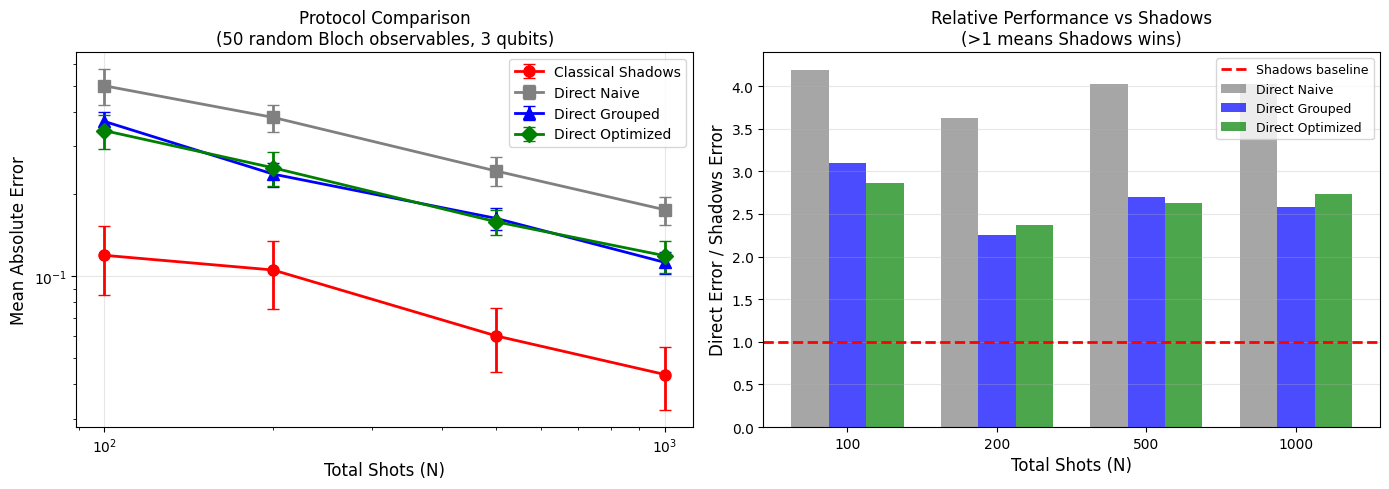


Plot saved to: results\bloch_m50_n3_benchmark_9_1_2026_1405\bloch_benchmark_results.png


In [24]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Mean Error vs Shots for all protocols
ax1 = axes[0]

protocol_styles = {
    'shadows': ('red', 'o', 'Classical Shadows'),
    'direct_naive': ('gray', 's', 'Direct Naive'),
    'direct_grouped': ('blue', '^', 'Direct Grouped'),
    'direct_optimized': ('green', 'D', 'Direct Optimized'),
}

for protocol, (color, marker, label) in protocol_styles.items():
    ns = []
    means = []
    stds = []
    for n_shots in N_SHOTS_GRID:
        rep_data = results[protocol][n_shots]
        mean_errors = [r['mean_error'] for r in rep_data]
        ns.append(n_shots)
        means.append(np.mean(mean_errors))
        stds.append(np.std(mean_errors))
    
    ax1.errorbar(ns, means, yerr=stds, marker=marker, color=color, 
                 label=label, capsize=4, linewidth=2, markersize=8)

ax1.set_xlabel('Total Shots (N)', fontsize=12)
ax1.set_ylabel('Mean Absolute Error', fontsize=12)
ax1.set_title(f'Protocol Comparison\n({M_OBSERVABLES} random Bloch observables, {N_QUBITS} qubits)', fontsize=12)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Ratio vs Shadows at each shot count
ax2 = axes[1]

x_pos = np.arange(len(N_SHOTS_GRID))
width = 0.25

for i, protocol in enumerate(['direct_naive', 'direct_grouped', 'direct_optimized']):
    ratios = []
    for n_shots in N_SHOTS_GRID:
        shadow_errors = [r['mean_error'] for r in results['shadows'][n_shots]]
        protocol_errors = [r['mean_error'] for r in results[protocol][n_shots]]
        ratio = np.mean(protocol_errors) / np.mean(shadow_errors)
        ratios.append(ratio)
    
    color = protocol_styles[protocol][0]
    label = protocol_styles[protocol][2]
    bars = ax2.bar(x_pos + i*width, ratios, width, label=label, color=color, alpha=0.7)

ax2.axhline(y=1, color='red', linestyle='--', linewidth=2, label='Shadows baseline')
ax2.set_xlabel('Total Shots (N)', fontsize=12)
ax2.set_ylabel('Direct Error / Shadows Error', fontsize=12)
ax2.set_title('Relative Performance vs Shadows\n(>1 means Shadows wins)', fontsize=12)
ax2.set_xticks(x_pos + width)
ax2.set_xticklabels([str(n) for n in N_SHOTS_GRID])
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'bloch_benchmark_results.png', dpi=150)
plt.show()

print(f"\nPlot saved to: {OUTPUT_DIR / 'bloch_benchmark_results.png'}")

## 9. Conclusions

In [37]:
# Final summary
print(f"\n{'='*70}")
print(f"CONCLUSIONS")
print(f"{'='*70}")
print(f"")
print(f"Configuration:")
print(f"  - Qubits: {N_QUBITS}")
print(f"  - Observables: {M_OBSERVABLES} random Bloch directions")
print(f"  - Circuit: GHZ state")
print(f"")
print(f"Resource Usage (circuits):")
print(f"  - Direct Naive:     {M_OBSERVABLES} circuits (one per observable)")
print(f"  - Direct Grouped:   {len(groups)} circuits (grouped by qubit)")
print(f"  - Direct Optimized: {len(groups)} circuits (grouped + smart allocation)")
print(f"  - Classical Shadows: N circuits (random Pauli, all data reused)")
print(f"")

# Find overall winner at highest shot count
n_max = N_SHOTS_GRID[-1]
best_protocol = min(PROTOCOLS, key=lambda p: np.mean([r['mean_error'] for r in results[p][n_max]]))
best_error = np.mean([r['mean_error'] for r in results[best_protocol][n_max]])

print(f"Results at N={n_max} shots:")
for protocol in PROTOCOLS:
    error = np.mean([r['mean_error'] for r in results[protocol][n_max]])
    print(f"  - {protocol:20s}: {error:.4f}")

print(f"")
print(f"Overall Winner: {best_protocol.upper()}")
print(f"")

# Compare shadows vs best direct baseline
shadows_error = np.mean([r['mean_error'] for r in results['shadows'][n_max]])
grouped_error = np.mean([r['mean_error'] for r in results['direct_grouped'][n_max]])

if shadows_error < grouped_error:
    ratio = grouped_error / shadows_error
    print(f"Key Finding: SHADOWS beats DirectGrouped by {ratio:.2f}x")
    print(f"")
    print(f"Explanation:")
    print(f"  - Even with grouping, direct methods split shots across {len(groups)} groups")
    print(f"  - Each group gets ~N/{len(groups)} = {n_max // len(groups)} shots")
    print(f"  - Shadows uses ALL N={n_max} shots for every observable (3x variance penalty)")
    print(f"  - Data reuse wins when M/G > 3, here: {M_OBSERVABLES}/{len(groups)} = {M_OBSERVABLES/len(groups):.1f} > 3")
else:
    ratio = shadows_error / grouped_error
    print(f"Key Finding: DirectGrouped beats Shadows by {ratio:.2f}x")
    print(f"")
    print(f"Explanation:")
    print(f"  - Grouping is very effective: {M_OBSERVABLES} observables -> {len(groups)} groups")
    print(f"  - Each group gets ~N/{len(groups)} = {n_max // len(groups)} shots")
    print(f"  - This outweighs shadows' 3x variance penalty")

print(f"")
print(f"Artifacts saved to: {OUTPUT_DIR}")


CONCLUSIONS

Configuration:
  - Qubits: 3
  - Observables: 30 random Bloch directions
  - Circuit: GHZ state

Resource Usage (circuits):
  - Direct Naive:     30 circuits (one per observable)
  - Direct Grouped:   13 circuits (grouped by qubit)
  - Direct Optimized: 13 circuits (grouped + smart allocation)
  - Classical Shadows: N circuits (random Pauli, all data reused)

Results at N=1000 shots:
  - shadows             : 0.0442
  - direct_naive        : 0.1381
  - direct_grouped      : 0.0952
  - direct_optimized    : 0.0897

Overall Winner: SHADOWS

Key Finding: SHADOWS beats DirectGrouped by 2.16x

Explanation:
  - Even with grouping, direct methods split shots across 13 groups
  - Each group gets ~N/13 = 76 shots
  - Shadows uses ALL N=1000 shots for every observable (3x variance penalty)
  - Data reuse wins when M/G > 3, here: 30/13 = 2.3 > 3

Artifacts saved to: results\bloch_m30_n3_benchmark_9_1_2026_1413


In [38]:
# Save results to JSON
output_data = {
    'config': {
        'm_observables': M_OBSERVABLES,
        'n_qubits': N_QUBITS,
        'n_groups': len(groups),
        'n_shots_grid': N_SHOTS_GRID,
        'n_replicates': N_REPLICATES,
        'seed': SEED,
    },
    'summary': {
        str(n_shots): {
            protocol: {
                'mean_error': float(np.mean([r['mean_error'] for r in results[protocol][n_shots]])),
                'std_error': float(np.std([r['mean_error'] for r in results[protocol][n_shots]])),
            }
            for protocol in PROTOCOLS
        }
        for n_shots in N_SHOTS_GRID
    },
    'ratios_vs_shadows': {
        str(n_shots): {
            protocol: float(np.mean([r['mean_error'] for r in results[protocol][n_shots]]) / 
                           np.mean([r['mean_error'] for r in results['shadows'][n_shots]]))
            for protocol in PROTOCOLS if protocol != 'shadows'
        }
        for n_shots in N_SHOTS_GRID
    },
    'winner': best_protocol,
}

with open(OUTPUT_DIR / 'summary.json', 'w') as f:
    json.dump(output_data, f, indent=2)

print(f"Results saved to: {OUTPUT_DIR / 'summary.json'}")

Results saved to: results\bloch_m30_n3_benchmark_9_1_2026_1413\summary.json
